In [1]:
import mne

In [2]:
mne.set_log_level('WARNING')


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    import PyQt5.QtCore
    %matplotlib qt
except ImportError:
    %matplotlib inline'
import pandas as pd
import scipy.io
import os
import mne
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
from mne.datasets import eegbci

# Select subjects
subjects = range(1, 2)

# Select runs
runs = [2, 3, 7]  # motor imagery 
raw_fnames = []
for subject in subjects:
    raw_fnames += eegbci.load_data(subject, runs)

Do you want to set the path:
    C:\Users\Patrick\mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y


In [5]:
raw_fnames

['C:\\Users\\Patrick\\mne_data\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\S001\\S001R02.edf',
 'C:\\Users\\Patrick\\mne_data\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\S001\\S001R03.edf',
 'C:\\Users\\Patrick\\mne_data\\MNE-eegbci-data\\files\\eegmmidb\\1.0.0\\S001\\S001R07.edf']

In [11]:
from mne import concatenate_raws
from mne.io import read_raw_edf

# Load data
raw_baseline = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames if "R02" in f])
raw_fist=concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames if "R03" in f or "R07" in f])
# Clean up channel names
raw_baseline.rename_channels(lambda x: x.strip('.'))
raw_fist.rename_channels(lambda x: x.strip('.'))
# Data is stored as a numpy array
print(type(raw_baseline._data))

# Metadata for the recording is available as an info object
print(raw_baseline.info)

# Check sample rate
print('sample rate:', raw_baseline.info['sfreq'], 'Hz')

# Gives the size of the data matrix
print('channels x samples:', raw_baseline._data.shape)

<class 'numpy.ndarray'>
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
sample rate: 160.0 Hz
channels x samples: (64, 9760)


In [12]:
# Data is stored as a numpy array
print(type(raw_fist._data))

# Metadata for the recording is available as an info object
print(raw_fist.info)

# Check sample rate
print('sample rate:', raw_fist.info['sfreq'], 'Hz')

# Gives the size of the data matrix
print('channels x samples:', raw_fist._data.shape)

<class 'numpy.ndarray'>
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
sample rate: 160.0 Hz
channels x samples: (64, 40000)


In [13]:

# Apply band-pass filter
raw_baseline.filter(7., 35., fir_design='firwin')
raw_fist.filter(7., 35., fir_design='firwin')


<RawEDF | S001R03.edf, 64 x 40000 (250.0 s), ~19.6 MB, data loaded>

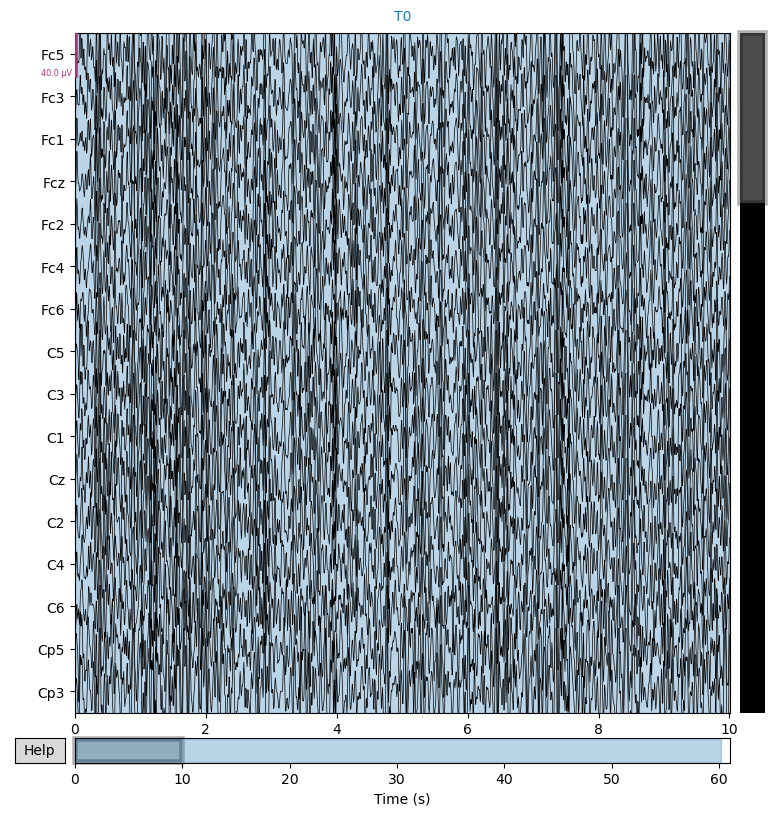

In [15]:
raw_baseline.plot(n_channels=16)

In [22]:
from mne import pick_types

# Select EEG channels
picks_base = pick_types(raw_baseline.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')
# Select EEG channels
picks_fist = pick_types(raw_fist.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

# Subsample electrodes (odd-numbered channels only)
picks_fist = picks_fist[::2]
picks_base=picks_base[::2]

In [18]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = 1., 2.
event_id=dict(left=2, right=3)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw_fist, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))

# Read epochs
epochs = Epochs(raw_fist,
                events,
                event_id,
                tmin,
                tmax,
                proj=True,
                picks=picks_fist,
                baseline=None,
                preload=True)

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Found 30 events
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc1, Fc2, Fc6, C3, Cz, C4, Cp5, Cp1, Cp2, Cp6, Fpz, Af7, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 32
 projs: []
 sfreq: 160.0 Hz
>
events x channels x samples: (30, 32, 161)


In [23]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = 0., 60.
event_id=dict(nothing=0)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw_baseline, event_id=dict(T0=0))
print('Found {} events'.format(events.shape[0]))

# Read epochs
epochs_basline = Epochs(raw_baseline,
                events,
                event_id,
                tmin,
                tmax,
                proj=True,
                picks=picks_base,
                baseline=None,
                preload=True)

# Inspect epochs
print(epochs_basline.info)
print('events x channels x samples:', epochs_basline._data.shape)

# Get labels
labels_baseline = epochs_basline.events[:, -1] - 2

Found 1 events
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5, Fc1, Fc2, Fc6, C3, Cz, C4, Cp5, Cp1, Cp2, Cp6, Fpz, Af7, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 32
 projs: []
 sfreq: 160.0 Hz
>
events x channels x samples: (1, 32, 9601)


In [24]:
epochs_data_baseline = 1e6 * epochs_basline.get_data()


In [27]:
epochs_data_baseline[0].shape

(32, 9601)

In [29]:
data_baseline=np.swapaxes(epochs_data_baseline[0],0,1)

In [30]:
data_baseline.shape

(9601, 32)

In [34]:
all_b=[]
for i,v in enumerate(data_baseline):
    if i+161>=len(data_baseline):
        break
    all_b.append(data_baseline[i:i+161])

In [38]:
all_b=np.array(all_b)

In [40]:
all_b=np.swapaxes(all_b,2,1)

In [41]:
all_b.shape

(9440, 32, 161)

In [54]:
all_b_train=all_b[:9000]
all_b_test=all_b[9000:]
all_b_train.shape

(9000, 32, 161)

In [55]:
latent_dim = 512 
keras.backend.clear_session()
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(1024, activation='gelu'),
      layers.Dense(512, activation='gelu'),
      layers.Dense(64, activation='gelu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(512, activation='gelu'),
      layers.Dense(1024, activation='gelu'),
      layers.Dense(32*161, activation='linear'),
      layers.Reshape((32, 161))
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [56]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())
autoencoder.fit(all_b_train,all_b_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(all_b_test, all_b_test))

Epoch 1/50
141/141 [==============================] - 9s 56ms/step - loss: 859.6401 - val_loss: 639.3200
Epoch 2/50
141/141 [==============================] - 8s 53ms/step - loss: 509.1354 - val_loss: 472.8106
Epoch 3/50
141/141 [==============================] - 9s 64ms/step - loss: 414.9856 - val_loss: 401.1152
Epoch 4/50
141/141 [==============================] - 9s 61ms/step - loss: 363.6742 - val_loss: 357.8285
Epoch 5/50
141/141 [==============================] - 9s 62ms/step - loss: 333.0351 - val_loss: 334.5587
Epoch 6/50
141/141 [==============================] - 8s 60ms/step - loss: 315.2451 - val_loss: 319.2088
Epoch 7/50
141/141 [==============================] - 9s 61ms/step - loss: 305.2375 - val_loss: 311.4712
Epoch 8/50
141/141 [==============================] - 9s 61ms/step - loss: 300.5665 - val_loss: 308.9543
Epoch 9/50
141/141 [==============================] - 9s 62ms/step - loss: 298.2979 - val_loss: 307.3992
Epoch 10/50
141/141 [==============================] - 

KeyboardInterrupt: 